<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Simple Linear Regression with Sacramento Real Estate Data

---

In this lab, you will hone your exploratory data analysis (EDA) skills and practice constructing linear regressions on a data set of Sacramento real estate sales.  The data set contains information on qualities of the property, location of the property, and time of sale.

### 1. Read in the Sacramento housing data set.

The file is stored in the `datasets` subfolder.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

houses = pd.read_csv('./datasets/sacramento_real_estate_transactions.csv')

In [6]:
houses.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


### 2. Conduct exploratory data analysis on this data set. 

If you discover any issues with the data, fix them to the best of your ability. **Report any notable findings.**

_**Note:** Zip codes often have leading zeros — e.g., 02215 = Boston, MA — which will often get knocked off automatically by many software programs like Python or Excel._

##### Cleaning Summary

Street and City: Untouched

ZIP: All ZIP codes have a length of 5 and start with 9.

State: 1 misspelling found; 'AC' should be corrected to 'CA'.

Beds and Baths: No issues noted.

sq__ft: Found negative values; these should be changed to positive. Additionally, there should be a flag called is_zero_area for cases where the area is zero, just in case zero values are valid.

Type: 1 row with the value 'Unkown' should be removed.

Sale Date: There are 5 dates in string format; these should be converted to the YYYYMMDD integer format.

Price: Found negative values; these should be changed to positive. Outliers are also present, we make them flagged.

Latitude, Longitude: There is 1 row where the values are swapped; these should be corrected to the right positions.

In [9]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   street     985 non-null    object 
 1   city       985 non-null    object 
 2   zip        985 non-null    int64  
 3   state      985 non-null    object 
 4   beds       985 non-null    int64  
 5   baths      985 non-null    int64  
 6   sq__ft     985 non-null    int64  
 7   type       985 non-null    object 
 8   sale_date  985 non-null    object 
 9   price      985 non-null    int64  
 10  latitude   985 non-null    float64
 11  longitude  985 non-null    float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.5+ KB


##### ZIP
all zip have length of 5 and start with 9, I think it's okay

In [11]:
houses['zip'].apply(lambda x: len(str(x))).value_counts()                  # all zip have length of 5

zip
5    985
Name: count, dtype: int64

In [12]:
houses['zip'].apply(lambda x: str(x)[0]).value_counts()                    # all zip start with 9

zip
9    985
Name: count, dtype: int64

##### State
found 1 row that state = 'AC', it should be 'CA', so I fix it

In [14]:
houses['state'].value_counts()                                             # 1 misspell found AC instead of CA

state
CA    984
AC      1
Name: count, dtype: int64

In [15]:
houses.loc[houses['state'] == 'AC', 'state'] = 'CA'                        # Clean 1 misspell

##### Beds

In [17]:
houses['beds'].value_counts()

beds
3    413
4    258
2    133
0    108
5     59
1     10
6      3
8      1
Name: count, dtype: int64

##### Baths

In [19]:
houses['baths'].value_counts()

baths
2    544
1    180
3    132
0    108
4     19
5      2
Name: count, dtype: int64

##### sq__ft
Found negative area, clean to positive

In [21]:
houses['sq__ft'].describe()

count     985.000000
mean     1312.918782
std       856.123224
min      -984.000000
25%       950.000000
50%      1304.000000
75%      1718.000000
max      5822.000000
Name: sq__ft, dtype: float64

In [22]:
houses.loc[houses['sq__ft'] < 0, 'sq__ft'] = houses['sq__ft'].abs()          # Make the negative sq__ft to positive

##### Type
There is 1 'Unkown', so I remove it

In [24]:
houses['type'].value_counts()

type
Residential     917
Condo            54
Multi-Family     13
Unkown            1
Name: count, dtype: int64

In [25]:
houses[houses['type'] == 'Unkown']

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
757,6007 MARYBELLE LN,SHINGLE SPRINGS,95682,CA,0,0,0,Unkown,Fri May 16 00:00:00 EDT 2008,275000,38.64347,-120.888183


In [26]:
houses = houses[houses['type'] != 'Unkown']      # Remove

##### Sale Date

It's in the format containing timezone, I format it as integer for easier to compare.

In [28]:
houses['sale_date'].value_counts()

sale_date
Mon May 19 00:00:00 EDT 2008    268
Fri May 16 00:00:00 EDT 2008    263
Tue May 20 00:00:00 EDT 2008    177
Wed May 21 00:00:00 EDT 2008    158
Thu May 15 00:00:00 EDT 2008    118
Name: count, dtype: int64

In [29]:
# Remove timezone information and convert to datetime
houses['sale_date'] = pd.to_datetime(houses['sale_date'].str.replace('EDT', '').str.strip())

# Convert to YYYYMMDD format as integer
houses['sale_date'] = houses['sale_date'].dt.strftime('%Y%m%d').astype(int)

In [30]:
houses['sale_date'].value_counts()

sale_date
20080519    268
20080516    263
20080520    177
20080521    158
20080515    118
Name: count, dtype: int64

##### Price

In [32]:
houses['price'].describe()

count       984.000000
mean     233673.995935
std      139153.311840
min     -210944.000000
25%      145000.000000
50%      213723.500000
75%      300000.000000
max      884790.000000
Name: price, dtype: float64

In [33]:
houses.loc[houses['price'] < 0, 'price'] = houses['price'].abs()          # Make the negative price to positive

In [34]:
houses['price'].describe()

count       984.000000
mean     234102.743902
std      138430.061196
min        1551.000000
25%      145000.000000
50%      213723.500000
75%      300000.000000
max      884790.000000
Name: price, dtype: float64

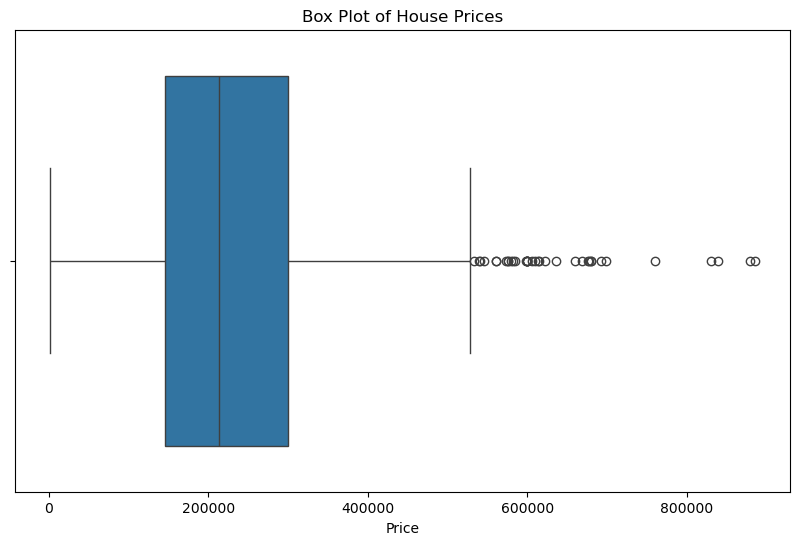

In [35]:
# Check Distribution
# Create a box plot for the 'price' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=houses['price'])

plt.title('Box Plot of House Prices')
plt.xlabel('Price')

plt.show()

##### latitude, longitude

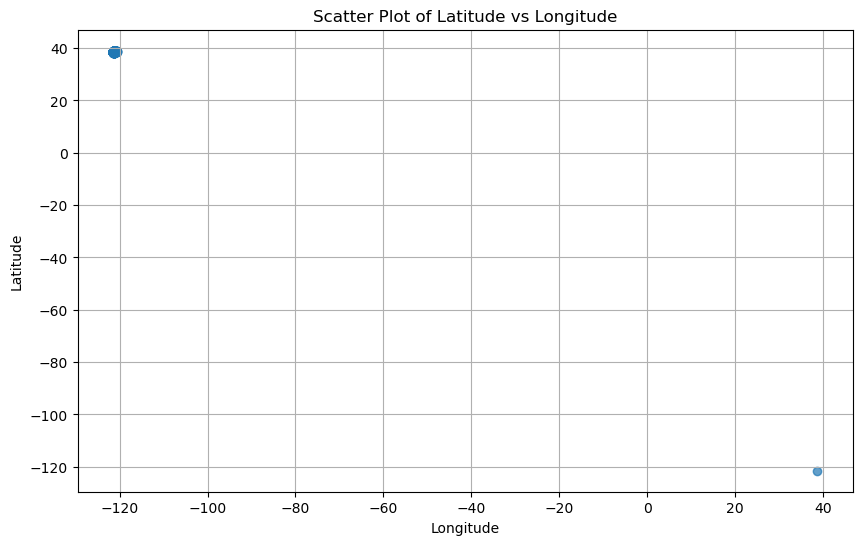

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(houses['longitude'], houses['latitude'], alpha=0.7)

# Add titles and labels
plt.title('Scatter Plot of Latitude vs Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.grid()
plt.show()

In [38]:
houses[houses['longitude'] > 20]

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
703,1900 DANBROOK DR,SACRAMENTO,95835,CA,1,1,984,Condo,20080516,210944,-121.503471,38.668433


In [39]:
## Swap
houses.loc[703, 'latitude'], houses.loc[703, 'longitude'] = (
    houses.loc[703, 'longitude'],
    houses.loc[703, 'latitude']
)

In [40]:
houses.loc[703]

street       1900 DANBROOK DR
city               SACRAMENTO
zip                     95835
state                      CA
beds                        1
baths                       1
sq__ft                    984
type                    Condo
sale_date            20080516
price                  210944
latitude            38.668433
longitude         -121.503471
Name: 703, dtype: object

##### Make flag about zero area

In [42]:
houses['is_zero_area'] = houses['sq__ft'].apply(lambda x: 1 if x == 0 else 0)

##### Make flag about outlier prices

In [44]:
# Find the lower bound and upper bound of outliers using IQR
Q1 = houses['price'].quantile(0.25)
Q3 = houses['price'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag
houses['is_outlier_price'] = houses['price'].apply(lambda x: 1 if (x < lower_bound or x > upper_bound) else 0)

In [45]:
houses.describe()

,zip,beds,baths,sq__ft,sale_date,price,latitude,longitude,is_zero_area,is_outlier_price
count,984.000000,984.000000,984.000000,984.000000,9.840000e+02,984.000000,984.000000,984.000000,984.000000,984.000000
mean,95750.767276,2.914634,1.778455,1316.253049,2.008052e+07,234102.743902,38.607696,-121.356458,0.172764,0.037602
std,85.191184,1.305295,0.894031,852.449931,2.131149e+00,138430.061196,0.145502,0.137540,0.378236,0.190328
min,95603.000000,0.000000,0.000000,0.000000,2.008052e+07,1551.000000,38.241514,-121.551704,0.000000,0.000000
25%,95660.000000,2.000000,1.000000,955.000000,2.008052e+07,145000.000000,38.482714,-121.446157,0.000000,0.000000
50%,95762.000000,3.000000,2.000000,1304.000000,2.008052e+07,213723.500000,38.626257,-121.376277,0.000000,0.000000
75%,95828.000000,4.000000,2.000000,1718.500000,2.008052e+07,300000.000000,38.695611,-121.295804,0.000000,0.000000
max,95864.000000,8.000000,5.000000,5822.000000,2.008052e+07,884790.000000,39.020808,-120.597599,1.000000,1.000000


When you've finished cleaning or have made a good deal of progress cleaning, it's always a good idea to save your work. Use the pandas `to_csv` method to export your cleaned dataset.

```python
# example -- your dataframe name may be different
dataframe.to_csv('./datasets/sacramento_cleaned_dataframe.csv', index=False)

```

In [47]:
# houses.to_csv('./datasets/sacramento_cleaned_dataframe.csv', index=False)

In [48]:
houses = pd.read_csv('./datasets/sacramento_cleaned_dataframe.csv')      # for next activity

In [49]:
houses.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,is_zero_area,is_outlier_price
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,20080521,59222,38.631913,-121.434879,0,0
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,20080521,68212,38.478902,-121.431028,0,0
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,20080521,68880,38.618305,-121.443839,0,0
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,20080521,69307,38.616835,-121.439146,0,0
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,20080521,81900,38.519470,-121.435768,0,0


### 3. Our goal will be to predict price. List variables that you think qualify as predictors of price in an SLR (Simple Linear Regression) model.

For each of the variables you believe should be considered, generate a plot showing the relationship between the independent and dependent variables.

In [51]:
# It's very make sense that the area must be the key variable
# Let check the correlation first

houses.corr(numeric_only = True)

# The correlation between sq__ft and price is only 0.33

,zip,beds,baths,sq__ft,sale_date,price,latitude,longitude,is_zero_area,is_outlier_price
zip,1.000000,0.123845,0.067695,0.129042,-0.018685,-0.093145,-0.290293,-0.540461,-0.275598,-0.069729
beds,0.123845,1.000000,0.838951,0.683099,-0.005691,0.343575,-0.291495,-0.046721,-0.553223,0.094830
baths,0.067695,0.838951,1.000000,0.664714,0.025550,0.417660,-0.235776,0.023596,-0.446254,0.138684
sq__ft,0.129042,0.683099,0.664714,1.000000,0.051169,0.334780,-0.383364,-0.173660,-0.705998,0.095605
sale_date,-0.018685,-0.005691,0.025550,0.051169,1.000000,0.050538,-0.043574,-0.001414,0.013482,0.012234
price,-0.093145,0.343575,0.417660,0.334780,0.050538,1.000000,-0.039650,0.285146,0.073610,0.579582
latitude,-0.290293,-0.291495,-0.235776,-0.383364,-0.043574,-0.039650,1.000000,0.389364,0.461209,0.059321
longitude,-0.540461,-0.046721,0.023596,-0.173660,-0.001414,0.285146,0.389364,1.000000,0.353837,0.224282
is_zero_area,-0.275598,-0.553223,-0.446254,-0.705998,0.013482,0.073610,0.461209,0.353837,1.000000,0.121638
is_outlier_price,-0.069729,0.094830,0.138684,0.095605,0.012234,0.579582,0.059321,0.224282,0.121638,1.000000


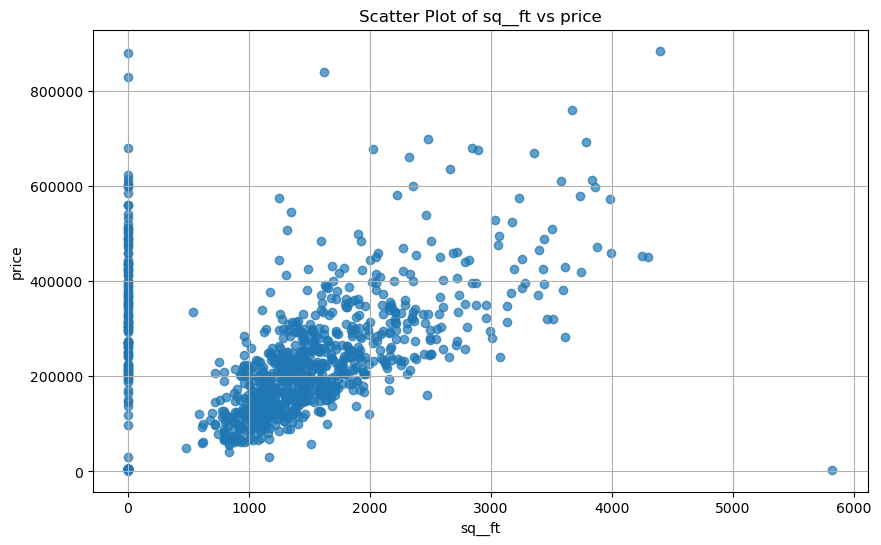

In [52]:
# According to the plot, the place with area of 0 may cause the low correlation
# And also the outlier of price of 0

plt.figure(figsize=(10, 6))
plt.scatter(houses['sq__ft'], houses['price'], alpha=0.7)

# Add titles and labels
plt.title('Scatter Plot of sq__ft vs price')
plt.xlabel('sq__ft')
plt.ylabel('price')

# Show the plot
plt.grid()
plt.show()

In [53]:
houses[(houses['is_zero_area'] == 0) & (houses['is_outlier_price'] == 0)].corr(numeric_only = True)

# By remove the zero area and outlier price, it seems okay
# From the correlation matrix -- beds, baths and sq__ft are reasonable variables to predict prices.
# Beside of mathemaically sense, it's also make sense in real world situation. The places with more beds, baths and area, they're more pricey.

,zip,beds,baths,sq__ft,sale_date,price,latitude,longitude,is_zero_area,is_outlier_price
zip,1.000000,-0.056901,-0.081526,-0.076544,-0.017578,-0.211360,-0.125278,-0.559223,NaN,NaN
beds,-0.056901,1.000000,0.646850,0.686349,0.040934,0.426182,-0.120789,0.023841,NaN,NaN
baths,-0.081526,0.646850,1.000000,0.727065,0.085750,0.486374,-0.105559,0.069759,NaN,NaN
sq__ft,-0.076544,0.686349,0.727065,1.000000,0.094051,0.672334,-0.122826,0.081817,NaN,NaN
sale_date,-0.017578,0.040934,0.085750,0.094051,1.000000,0.114942,-0.060311,0.024070,NaN,NaN
price,-0.211360,0.426182,0.486374,0.672334,0.114942,1.000000,0.026894,0.214724,NaN,NaN
latitude,-0.125278,-0.120789,-0.105559,-0.122826,-0.060311,0.026894,1.000000,0.339499,NaN,NaN
longitude,-0.559223,0.023841,0.069759,0.081817,0.024070,0.214724,0.339499,1.000000,NaN,NaN
is_zero_area,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_outlier_price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# Make a new DataFrame

houses_clean = houses[(houses['is_zero_area'] == 0) & (houses['is_outlier_price'] == 0)]

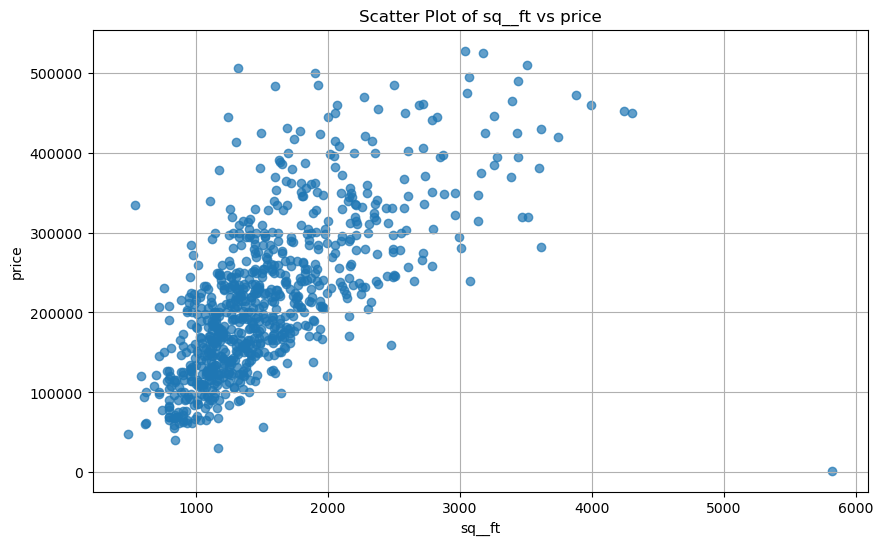

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(houses_clean['sq__ft'], houses_clean['price'], alpha=0.7)

# Add titles and labels
plt.title('Scatter Plot of sq__ft vs price')
plt.xlabel('sq__ft')
plt.ylabel('price')

# Show the plot
plt.grid()
plt.show()

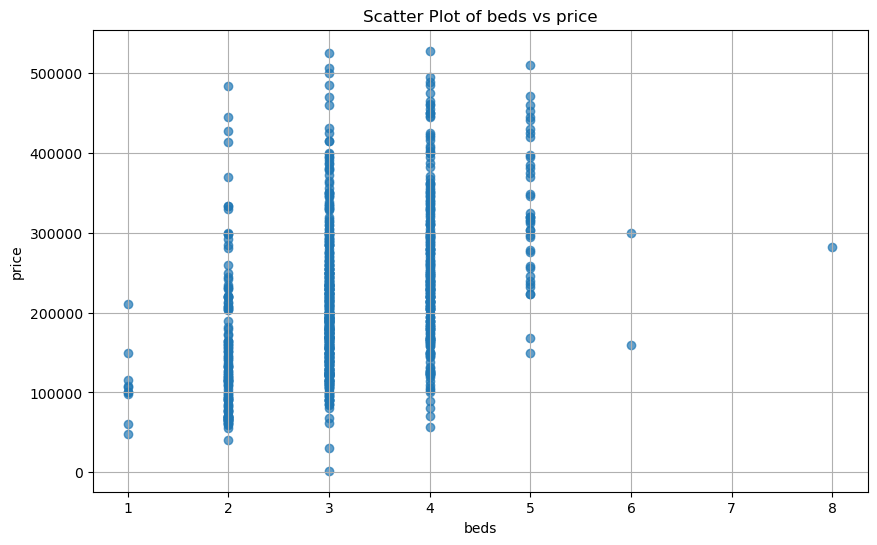

In [56]:
plt.figure(figsize=(10, 6))
plt.scatter(houses_clean['beds'], houses_clean['price'], alpha=0.7)

# Add titles and labels
plt.title('Scatter Plot of beds vs price')
plt.xlabel('beds')
plt.ylabel('price')

# Show the plot
plt.grid()
plt.show()

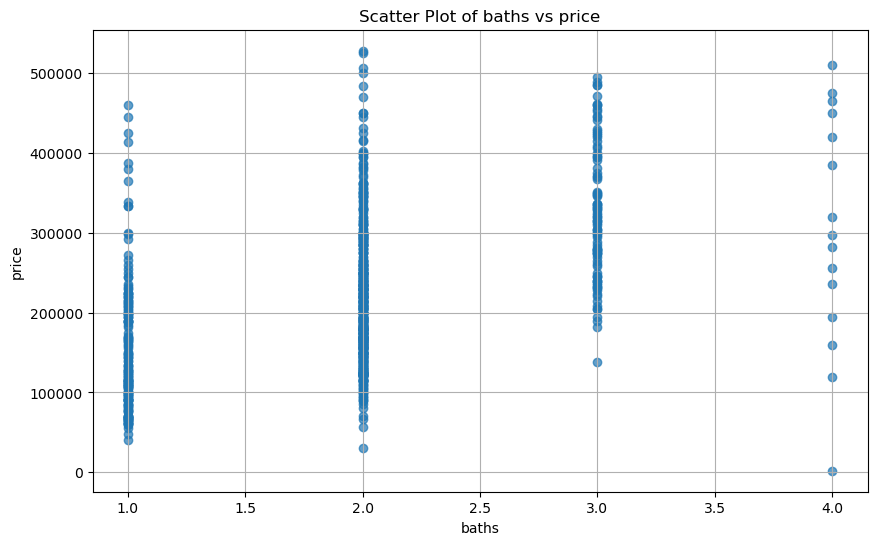

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(houses_clean['baths'], houses_clean['price'], alpha=0.7)

# Add titles and labels
plt.title('Scatter Plot of baths vs price')
plt.xlabel('baths')
plt.ylabel('price')

# Show the plot
plt.grid()
plt.show()

### 4. Which variable would be the best predictor of `y` in an SLR (Simple Linear Regression) model? Why?

In [59]:
# I think area sq__ft is the best predictors
# It makes sense in real world
# Their correlation is the highest among the variables

### 5. Write a function that will take in two lists, `x` and `y`, and returns the intercept and slope coefficients that minimize SSE (Sum of Squared Errors). 

`y` is the target variable, and `x` is the predictor variable.

**Don't use scikit-learn for this**. Instead, use numpy and scipy.

The slope and intercept of simple linear regression can be calculated by using certain summary statistics. In particular, we'll need to know:

- $\bar{x}$, the mean of `x`
- $\bar{y}$, the mean of `y`
- $s_{x}$, the standard deviation of `x`
- $s_{y}$, the standard deviation of `y`
- $r_{xy}$, the correlation of `x` and `y`

Given these summary statistics, the **coefficient on `X`** (or the slope) can be given by $\beta_{1} = r_{xy} * \frac{s_{y}}{s_{x}}$. The **intercept of the model** can be given by $\beta_{0} = \bar{y} - \beta_{1}\bar{x}$.

Your function should take in `x` and `y`, then use the above summary statistics to calculate the slope and intercept.

- **Test your function on price and the variable you determined was the best predictor in Question #4.**
- **Report the slope and intercept.**

In [61]:
def simple_linear_regression(x, y):

    # To use this function, we assume list x and list y have same lengths
    
    mean_x = sum(x) / len(x)
    mean_y = sum(y) / len(y)

    std_x = np.std(x)
    std_y = np.std(y)

    r_xy = np.corrcoef(x, y)[0,1]
 
    # Slope
    slope = r_xy * std_y / std_x
    
    # intercept
    intercept = mean_y - slope * mean_x
    
    return slope, intercept

In [62]:
# Let the predictor be sq__ft and the target is price

x = houses_clean['sq__ft'].tolist()
y = houses_clean['price'].tolist()

# Apply function

z = simple_linear_regression(x, y)

print(f'The slope is {z[0]}, and the intercept is {z[1]}')

The slope is 106.22424010827118, and the intercept is 52678.36327289365


### 6. Now interpret the intercept and the slope.

In [64]:
# The model is price = 106 * sq__ft + 52678, rounded
# The base price of each property is approximately $52,678, and the cost is around $106 per square foot.

### 7. Give an example of how this model could be used for prediction and how it could be used for inference. 

**Be sure to make it clear which example is associated with prediction and which is associated with inference.**

In [66]:
# Prediction
# The model will predict and use for calculate the price of new place, if the area (sq__ft) is known.
# i.e., the new place is 100 square feet, then the estimate price will be 106 * 100 + 52678 = $63278

# Inference
# The model shows the relationship between the area (sq__ft) and price. It make us understand how change in area (sq__ft) affects the price.
# i.e., the price will go up $106 per 1 increasing square foot

### 8: Using the model you came up with in Question #5, calculate and plot the residuals.

In [68]:
predicted = [z[1] + z[0] * value for value in x]
residuals = [actual - pred for actual, pred in zip(y, predicted)]

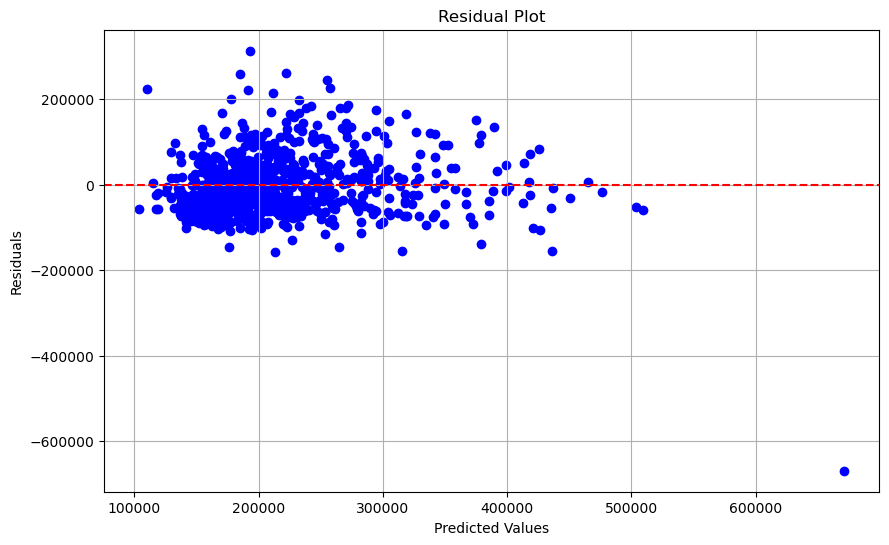

In [69]:
# Plot

plt.figure(figsize=(10, 6))
plt.scatter(predicted, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')  # Line at y=0 for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

---

## Dummy Variables

It is important to be cautious with categorical variables, which represent distinct groups or categories, when building a regression. If put in a regression "as-is," categorical variables represented as integers will be treated like *continuous* variables.

That is to say, instead of group "3" having a different effect on the estimation than group "1" it will estimate literally 3 times more than group 1. 

For example, if occupation category "1" represents "analyst" and occupation category "3" represents "barista", and our target variable is salary, if we leave this as a column of integers then barista will always have `beta*3` the effect of analyst.

This will almost certainly force the beta coefficient to be something strange and incorrect. Instead, we can re-represent the categories as multiple "dummy coded" columns.



#### A Word of Caution When Creating Dummies

Let's touch on precautions we should take when dummy coding.

**If you convert a qualitative variable to dummy variables, you want to turn a variable with N categories into N-1 variables.**

> **Scenario 1:** Suppose we're working with the variable "sex" or "gender" with values "M" and "F". 

You should include in your model only one variable for "sex = F" which takes on 1 if sex is female and 0 if sex is not female! Rather than saying "a one unit change in X," the coefficient associated with "sex = F" is interpreted as the average change in Y when sex = F relative to when sex = M.

| Female | Male | 
|-------|------|
| 0 | 1 | 
| 1 | 0 |
| 0 | 1 |
| 1 | 0 |
| 1 | 0 |
_As we can see a 1 in the female column indicates a 0 in the male column. And so, we have two columns stating the same information in different ways._

> Scenario 2: Suppose we're modeling revenue at a bar for each of the days of the week. We have a column with strings identifying which day of the week this observation occurred in.

We might include six of the days as their own variables: "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday". **But not all 7 days.**  

|Monday | Tuesday | Wednesday | Thursday | Friday | Saturday | 
|-------|---------|-----------|----------|--------|----------|
| 1     | 0       |0          |      0   |0       | 0        | 
| 0     | 1       |0          |      0   |0       | 0        | 
| 0     | 0       |1          |      0   |0       | 0        | 
| 0     | 0       |0          |      1   |0       | 0        | 
| 0     | 0       |0          |      0   |1       | 0        | 
| 0     | 0       |0          |      0   |0       | 1        | 
| 0     | 0       |0          |      0   |0       | 0        | 

_As humans we can infer from the last row that if its is not Monday, Tuesday, Wednesday, Thursday, Friday or Saturday, it must be Sunday. Models work the same way._

The coefficient for Monday is then interpreted as the average change in revenue when "day = Monday" relative to "day = Sunday." The coefficient for Tuesday is interpreted as the average change in revenue when "day = Tuesday" relative to "day = Sunday" and so on.

The category you leave out, which the other columns are *relative to*, is often referred to as the **reference category**.

### 9. Use the `pd.get_dummies` function to convert the `type` column into dummy-coded variables.

In [72]:
type_dummies = pd.get_dummies(houses_clean, columns=['type'], drop_first=True)

In [73]:
houses_clean['type'].value_counts()

type
Residential     737
Condo            42
Multi-Family     13
Name: count, dtype: int64

### 10. Check the dummy columns you've created. Do they all make sense?

Use `.head()` on the new dataframe you've created. Depending on how you cleaned the data earlier in this notebook, there may be a dummy column that needs to be removed. Check that all the columns you've created make sense, and if any of the columns seem to be errors, drop them. If there don't appear to be any errors, then move on to the next step!

In [75]:
# So the 'Condo' comes when type_Multi-Family and type_Residential are False
type_dummies.head()

,street,city,zip,state,beds,baths,sq__ft,sale_date,price,latitude,longitude,is_zero_area,is_outlier_price,type_Multi-Family,type_Residential
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,20080521,59222,38.631913,-121.434879,0,0,False,True
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,20080521,68212,38.478902,-121.431028,0,0,False,True
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,20080521,68880,38.618305,-121.443839,0,0,False,True
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,20080521,69307,38.616835,-121.439146,0,0,False,True
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,20080521,81900,38.519470,-121.435768,0,0,False,True


In [76]:
# For easy to use in model, let False = 0 and True = 1
type_dummies['type_Multi-Family'] = type_dummies['type_Multi-Family'].apply(lambda x: 1 if x else 0)
type_dummies['type_Residential'] = type_dummies['type_Residential'].apply(lambda x: 1 if x else 0)

In [77]:
type_dummies

,street,city,zip,state,beds,baths,sq__ft,sale_date,price,latitude,longitude,is_zero_area,is_outlier_price,type_Multi-Family,type_Residential
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,20080521,59222,38.631913,-121.434879,0,0,0,1
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,20080521,68212,38.478902,-121.431028,0,0,0,1
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,20080521,68880,38.618305,-121.443839,0,0,0,1
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,20080521,69307,38.616835,-121.439146,0,0,0,1
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,20080521,81900,38.519470,-121.435768,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,9169 GARLINGTON CT,SACRAMENTO,95829,CA,4,3,2280,20080515,232425,38.457679,-121.359620,0,0,0,1
980,6932 RUSKUT WAY,SACRAMENTO,95823,CA,3,2,1477,20080515,234000,38.499893,-121.458890,0,0,0,1
981,7933 DAFFODIL WAY,CITRUS HEIGHTS,95610,CA,3,2,1216,20080515,235000,38.708824,-121.256803,0,0,0,1
982,8304 RED FOX WAY,ELK GROVE,95758,CA,4,2,1685,20080515,235301,38.417000,-121.397424,0,0,0,1


### 11. Build what you think may be the best MLR (Multiple Linear Regression) model predicting `price`. 

Choose at least three variables, and build a model that uses them to predict price. At least one of the variables you choose should be a dummy-coded variable. (This can be one we created before or a new one.) 

You may need to load in the scikit-learn API:

```python
from sklearn.linear_model import LinearRegression

model = LinearRegression()
```

In [79]:
from sklearn.linear_model import LinearRegression

In [80]:
# Set Features and Target
X = type_dummies[['sq__ft', 'beds', 'baths','type_Multi-Family','type_Residential']]
y = type_dummies['price']

# Make Model
model = LinearRegression()
model.fit(X, y)

# Make predictions on the test set
y_pred = model.predict(X)

print(f'Intercept: {model.intercept_}')
print(f'Slope coefficients: {model.coef_}')

Intercept: 39676.45608685602
Slope coefficients: [   110.60426361 -11302.8720081    5644.30047878  -8479.06358154
  34140.95002879]


price = 39676 + 111 sq__ft - 11303 beds + 5644 baths - 8479 Multi_Family + 34141 Residential

### 12. Plot the true price vs the predicted price to evaluate your MLR (Multiple Linear Regression) visually.

You can use matplotlib or seaborn.

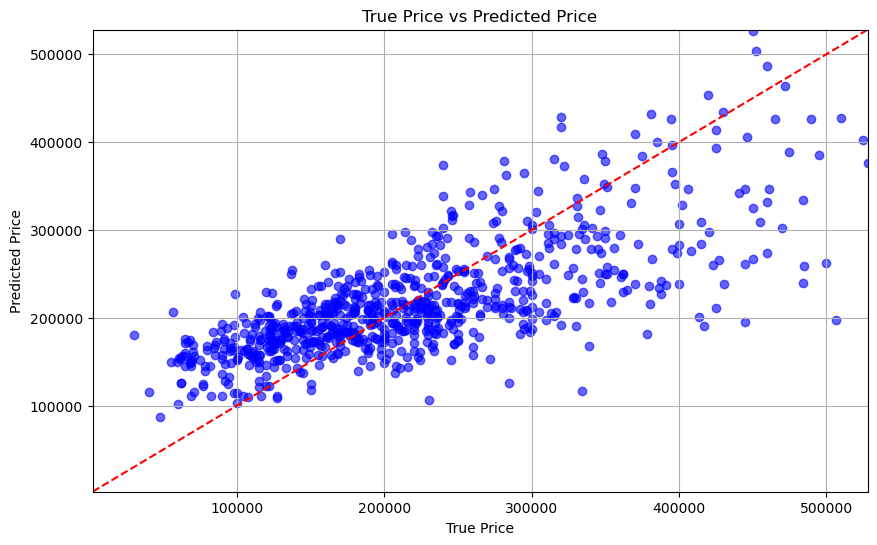

In [83]:
# Plotting true vs predicted prices

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color = 'blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.title('True Price vs Predicted Price')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.xlim([y.min(), y.max()])
plt.ylim([y.min(), y.max()])
plt.grid(True)
plt.show()

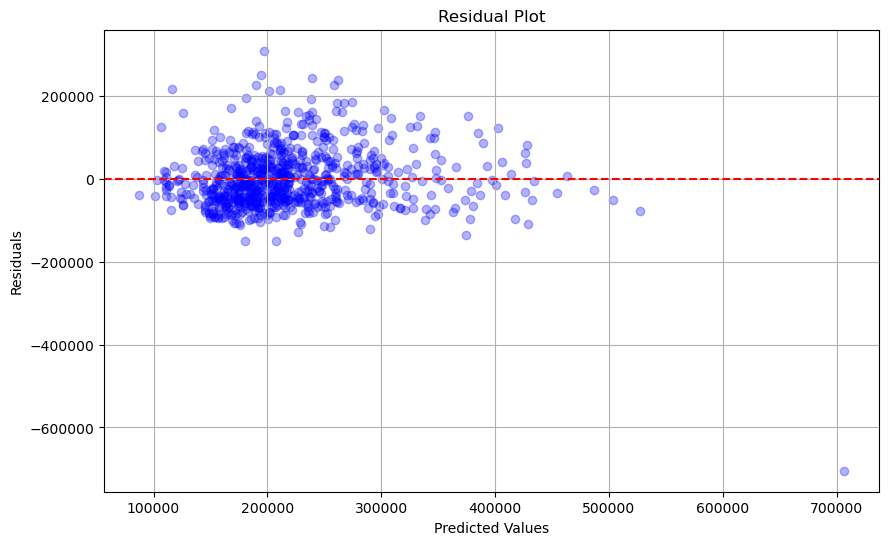

In [84]:
# Residual Plot

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y - y_pred, color = 'blue', alpha = 0.3)
plt.axhline(0, color='red', linestyle='--')  # Line at y=0 for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

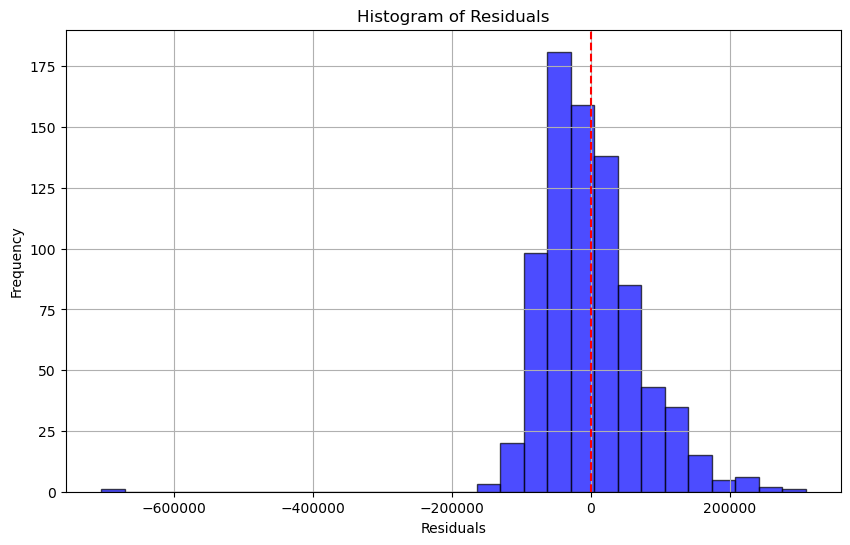

In [85]:
# Residuals
residuals = y - y_pred

# Residuals Histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(0, color='red', linestyle='--')  # Line at x=0 for reference
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()

# The residual of model looks normal distributed

### 13. List the five assumptions for an MLR (Multiple Linear Regression) model. 

Indicate which ones are the same as the assumptions for an SLR model. 

In [87]:
# Linearity, Independence, Homoscedasticity, and Normality of Residuals are assumptions shared between MLR and SLR.
# No Multicollinearity is unique to MLR, as SLR involves only one predictor, so multicollinearity is not an issue.

### 14. Pick at least two assumptions and explain whether or not you believe them to be met for your model, and explain why.

In [89]:
# Linearity - the area is related to the prices, the correlation table has proved this point.
# No Multicollinearity - those variables may be not independent, especially beds, baths and sq__ft. 
#               Because of the place with more area is likely to have more bedrooms and bathrooms.
# Normality of Residuals - with the plot, it seems okay

### 15. [Bonus] Generate a table showing the point estimates, standard errors, t-scores, p-values, and 95% confidence intervals for the model you built. 

**Write a few sentences interpreting some of the output.**

> **Hint:** scikit-learn does not have this functionality built in, but statsmodels does in the `summary` method.  To fit the statsmodels model use something like the following.  There is one big caveat here, however!  `statsmodels.OLS` does _not_ add an intercept to your model, so you will need to do this explicitly by adding a column filled with the number 1 to your X matrix

```python
import statsmodels.api as sm

# The Default here is Linear Regression (ordinary least squares regression OLS)
model = sm.OLS(y,X).fit()
```

In [91]:
# let me skip this one

### 16. Regression Metrics

Implement a function called `r2_adj()` that will calculate $R^2_{adj}$ for a model. 

In [93]:
def r2_adj(model, X, y):
    # Number of observations
    n = X.shape[0]
    # Number of predictors
    p = X.shape[1]
    # Calculate R-squared
    r2 = model.score(X, y)
    # Calculate adjusted R-squared
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

In [94]:
r2_adj(model, X, y)

0.45954062276738905

### 17. Metrics, metrics, everywhere...

Calculate and interpret at least three regression metrics. How well does your model perform?

In [96]:
r2 = model.score(X, y)
r2

0.46295692730109705

In [97]:
from sklearn import metrics

# Mean Absolute Errors
mae = metrics.mean_absolute_error(y, y_pred)
mae

53205.76291958075

In [98]:
# Mean Square Error
mse = metrics.mean_squared_error(y, y_pred)
mse

5111951117.695767

In [99]:
# Root Mean Square
rmse = metrics.root_mean_squared_error(y, y_pred)
rmse

71497.90988340686

In [100]:
# The model is not fit enough, r2 is so-so and mae, mse, rmse are way too far from 0
# But mae, mse, rmse are high because the prices are not standardized, right?

### 18. Model Iteration

Adjust your model by adding or removing a variable. Then calculate the same regression metrics as you used in question 17. Has your model performance increased or decreased?

In [102]:
type_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 792 entries, 0 to 983
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   street             792 non-null    object 
 1   city               792 non-null    object 
 2   zip                792 non-null    int64  
 3   state              792 non-null    object 
 4   beds               792 non-null    int64  
 5   baths              792 non-null    int64  
 6   sq__ft             792 non-null    int64  
 7   sale_date          792 non-null    int64  
 8   price              792 non-null    int64  
 9   latitude           792 non-null    float64
 10  longitude          792 non-null    float64
 11  is_zero_area       792 non-null    int64  
 12  is_outlier_price   792 non-null    int64  
 13  type_Multi-Family  792 non-null    int64  
 14  type_Residential   792 non-null    int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 99.0+ KB


In [103]:
sale_date_dummies = pd.get_dummies(type_dummies, columns=['sale_date'], drop_first=True)

In [104]:
sale_date_dummies['sale_date_20080516'] = sale_date_dummies['sale_date_20080516'].apply(lambda x: 1 if x else 0)
sale_date_dummies['sale_date_20080519'] = sale_date_dummies['sale_date_20080519'].apply(lambda x: 1 if x else 0)
sale_date_dummies['sale_date_20080520'] = sale_date_dummies['sale_date_20080520'].apply(lambda x: 1 if x else 0)
sale_date_dummies['sale_date_20080521'] = sale_date_dummies['sale_date_20080521'].apply(lambda x: 1 if x else 0)

In [105]:
sale_date_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 792 entries, 0 to 983
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   street              792 non-null    object 
 1   city                792 non-null    object 
 2   zip                 792 non-null    int64  
 3   state               792 non-null    object 
 4   beds                792 non-null    int64  
 5   baths               792 non-null    int64  
 6   sq__ft              792 non-null    int64  
 7   price               792 non-null    int64  
 8   latitude            792 non-null    float64
 9   longitude           792 non-null    float64
 10  is_zero_area        792 non-null    int64  
 11  is_outlier_price    792 non-null    int64  
 12  type_Multi-Family   792 non-null    int64  
 13  type_Residential    792 non-null    int64  
 14  sale_date_20080516  792 non-null    int64  
 15  sale_date_20080519  792 non-null    int64  
 16  sale_date_200

In [106]:
# Set New Features and Same Target
X2 = sale_date_dummies[['sq__ft', 'beds', 'baths','type_Multi-Family','type_Residential'
                        , 'sale_date_20080516'
                        , 'sale_date_20080519'
                        , 'sale_date_20080520'
                        , 'sale_date_20080521']]
y2 = sale_date_dummies['price']

# Make Model
model2 = LinearRegression()
model2.fit(X2, y2)

# Make predictions on the test set
y_pred2 = model2.predict(X2)

print(f'Intercept: {model2.intercept_}')
print(f'Slope coefficients: {model2.coef_}')

Intercept: 15803.509853083146
Slope coefficients: [   107.55827443 -10571.19360498   5843.02296731  -7647.56933687
  35433.58930295  26481.09317585  31833.97600932  35485.36074619
  20647.24346697]


In [107]:
r2_adj(model2,X2,y2)

0.46936452749939683

In [108]:
mae = metrics.mean_absolute_error(y, y_pred2)
mae

52895.34640456858

In [109]:
mse = metrics.mean_squared_error(y, y_pred2)
mse

4993489277.530815

In [110]:
rmse = metrics.root_mean_squared_error(y, y_pred2)
rmse

70664.62536185142

In [111]:
residuals = y - y_pred2

# Square the residuals
squared_errors = residuals ** 2

# Sum the squared errors to get SSE
SSE = np.sum(squared_errors)
SSE

3954843507804.4053

In [112]:
# It's slightly increasing. Just a little. The date of selling may have effects.

### 19. Bias vs. Variance

_(To be completed after the bias-variance tradeoff lecture.)_ At this point, do you think your model is high bias, high variance or in the sweet spot?

In [114]:
# I think the model is high bias, the model is not fit enough (r2_adj is only 0.469)